## Тема: Базовые понятия для анализа временных рядов


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
import pandas as pd
import numpy as np
from statsmodels.graphics import tsaplots
from statsmodels.stats import diagnostic
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import scipy

from load_dataset import Dataset
import plotting

1. (1 балл) Для чего нужно понятие стационарности в анализе временных рядов?
Перечислите все случаи и распишите свой ответ.


Стационарность ряда - один из важных критериев для анализа ряда и необходимое условие для предсказания ряда, т.к. модель эффективно работает только со случайной компонентой ряда. Сезонность и тренд (то есть зависимость от времени) необходимо исключить из ряда. 

2. (1 балла) Рассмотрите картинку data/images/ts_types.png.
a. Назовите ряды с гетероскедастичностью - a, c, e, i


b. Какие ряды имеют сезонность? - a, g, h, i
 

с. Какие ряды имеют цикличность?  - g, h


d. Какие ряды можно приблизить моделью интегрированного ряда? - a, c, e, i 


e. Какие ряды можно считать стационарными? - b, d, f

3. (2 балла) Рассмотрите один из графиков индекса Доу-Джонса (data/dataset/
dow_jones.csv). Предположим, вы можете сделать только одно
преобразование ряда, чтобы сделать его стационарным. Какое
преобразование вы выберете и почему? Сделайте это преобразование,
проверьте, получили ли вы белый шум.

In [4]:
dataset = Dataset('../data/dataset/')

<AxesSubplot:xlabel='2018-11-30'>

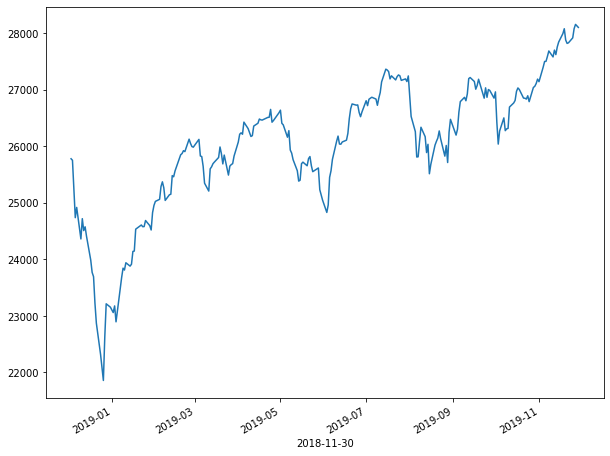

In [5]:
ts = dataset['dow_jones_0.csv']
ts.plot(figsize=(10, 8))

Ряд не стацонарен, обладает трендом и сезонностью, ± гомоскедастичнен, проверим стационарность

In [6]:
# нулевая гипотеза: ряд не стационарен, alpha = 0.05
p_value = adfuller(ts)[1]
p_value 

0.738676592902148

p_value > 0.05 - принимаем нулевую гипотезу - ряд не стационарен

<AxesSubplot:xlabel='2018-11-30'>

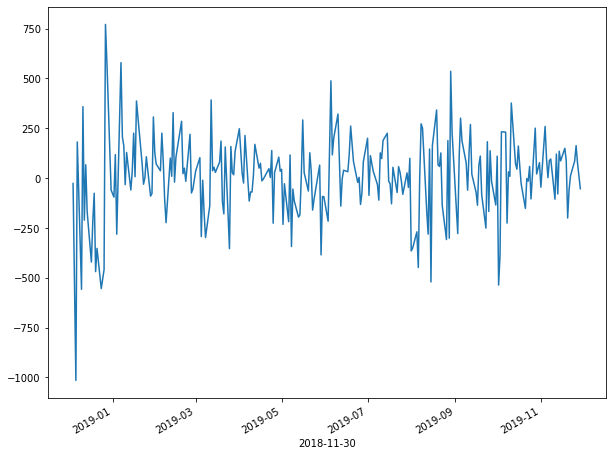

In [7]:
# выбираем одну операцию - сделаем дифференцирование
ts_diff = ts.diff()
ts_diff.plot(figsize=(10, 8))

Ряд похож на стационарный, проверим тестом Дикки-Фуллера

In [8]:
# Проверка стационарности тестом
def get_adfuller(ts, output=True):
    """Проверка стационарности стат. тестом Дикки-Фуллера
    ts - Series with datetime index: временной ряд  
    """
    p_value = adfuller(ts.dropna())[1]
    print(f'p_value = {p_value}')
    
    if output:
        if p_value < 0.05:
            print('Нулевую гипотезу нельзя принять, ряд стационарен')
        else:
            print('Нулевую гипотезу нельзя отвергнуть, ряд не стационарен') 
        
    return p_value

In [9]:
p_value = get_adfuller(ts_diff)

p_value = 7.270680965724108e-27
Нулевую гипотезу нельзя принять, ряд стационарен


4. (2 балла) Рассмотрите ряд data/dataset/stl_example.csv. Постройте для него
график автокорреляций. Обьясните закономерности, которые вы видите.

In [10]:
ts = dataset['stl_example.csv']

In [11]:
ts

2019-01-01 00:00:00    2.156403
2019-01-01 01:00:00    2.859954
2019-01-01 02:00:00    3.041739
2019-01-01 03:00:00    2.242690
2019-01-01 04:00:00    1.168226
                         ...   
2019-01-09 03:00:00    2.975522
2019-01-09 04:00:00    3.815204
2019-01-09 05:00:00    3.801927
2019-01-09 06:00:00    2.815091
2019-01-09 07:00:00    2.157788
Name: 0, Length: 200, dtype: float64

<AxesSubplot:>

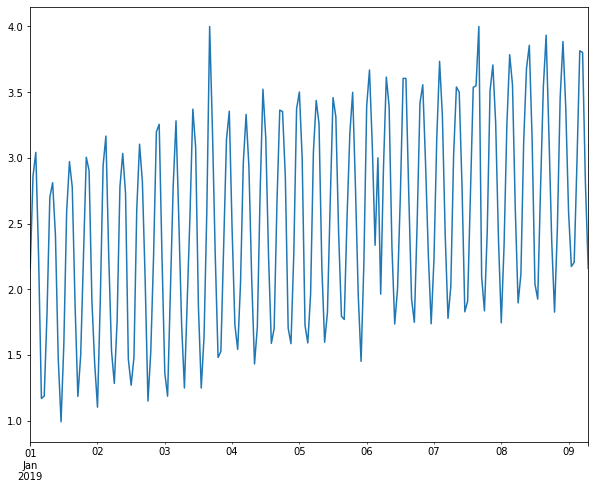

In [12]:
ts.plot(figsize=(10, 8))

Предворительные гипотезы - ряд не стационарен, присутствует восходящий тренд, гомоскедастичен, проверим стационарность

In [13]:
# Проверка на стационарность
# нулевая гипотеза: ряд не стационарен, alpha = 0.05
p_value = get_adfuller(ts)

p_value = 0.7592519528940866
Нулевую гипотезу нельзя отвергнуть, ряд не стационарен


Рассмотрим сезонность

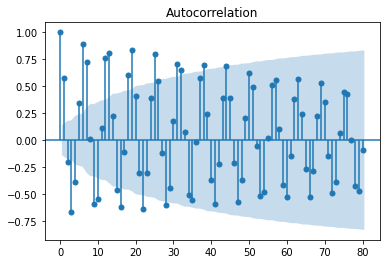

In [14]:
tsaplots.plot_acf(ts, lags=80);

Присутствует сезонность на нескольких уровнях - каждые 6 и 24 точек, далее продифференциируем

In [15]:
# дифференцирование
ts_diff = ts.diff(6).diff(24)
plotting.plot_ts(ts, ts_diff)

Loading BokehJS ...

In [16]:
# еще раз проверим на стационнарность
p_value = get_adfuller(ts_diff)

p_value = 1.9842152364182727e-06
Нулевую гипотезу нельзя принять, ряд стационарен


5. (4 балла) На семинаре, посвященном stl разложению мы находили период
сезонности сезонных временных рядов при помощи графика автокорреляций.
Однако, если бы мы захотели построить автоматическую систему определения
периода, мы бы уже не могли “вручную” анализировать каждый график. Таким
образом вам необходимо написать функцию get_seasonal_period(), которая бы
автоматически определяла период сезонных временных рядов, использую
автокорреляционную функцию.

In [17]:
ts

2019-01-01 00:00:00    2.156403
2019-01-01 01:00:00    2.859954
2019-01-01 02:00:00    3.041739
2019-01-01 03:00:00    2.242690
2019-01-01 04:00:00    1.168226
                         ...   
2019-01-09 03:00:00    2.975522
2019-01-09 04:00:00    3.815204
2019-01-09 05:00:00    3.801927
2019-01-09 06:00:00    2.815091
2019-01-09 07:00:00    2.157788
Name: 0, Length: 200, dtype: float64

In [18]:
def get_seasonal_period(ts, periods):
    """функция для автоматического определения периода сезонности временного ряда
    ts - Series with datetime index: временной ряд  
    periods - list: список потенциальных периодов"""
    result = []
    for period in periods:
        try:
            ts_diff = ts.diff(period)
            pvalue = get_adfuller(ts_diff, output=False)
            if pvalue < 0.05:
                result.append({"period": period, "p_value":pvalue})
        except ValueError:
            continue
    print(f"""Возможные топ-5 периоды сезонности: {[obj['period'] for obj in sorted(result, key=lambda item: item['p_value'])][:5]}""")
    return result

In [19]:
# задаем периоды 
periods = [i for i in range(1, int(ts.shape[0]/2), 2)]

In [20]:
result = get_seasonal_period(ts, periods)

p_value = 2.2185222490643138e-11
p_value = 1.230142730656583e-06
p_value = 1.4247262498931133e-08
p_value = 2.1222931163044784e-05
p_value = 9.394774099567944e-12
p_value = 1.610561422772213e-05
p_value = 2.6964703287438715e-07
p_value = 6.999823058372367e-06
p_value = 0.007057962477431459
p_value = 0.012403865012818873
p_value = 0.016194825851229264
p_value = 0.01711871370193345
p_value = 2.3235558807379786e-14
p_value = 0.03613261123902613
p_value = 0.04728286293820002
p_value = 0.005321909681521029
p_value = 0.031529901707349574
p_value = 0.020348955516486848
p_value = 0.08082014155921424
p_value = 0.053997130309398116
p_value = 0.024235294217770598
p_value = 0.0096041574017086
p_value = 3.329098277713247e-05
p_value = 0.005941669140199966
p_value = 0.01010995405027767
p_value = 0.02098298885055571
p_value = 0.11270716755233223
p_value = 0.07062237379329318
p_value = 0.007090707225487965
p_value = 0.15503275251833482
p_value = 0.16024410146267054
p_value = 2.1059115364123475e-12
p_v